# TP Integrador análisis de datos:

Se propone realizar el ciclo completo del desarrollo de un modelo de aprendizaje automático supervisado. Trabajaremos con un dataset de Kaggle con datos de por distintas estaciones metereológicas de Australia. El objetivo es predecir si lloverá o no al día siguiente (variable RainTomorrow), en función datos metereológicos del día actual.

### Dataset: 
El dataset weatherAUS es un dataset que contiene más de 140 mil observaciones climatológicas de estaciones meteorológicas en el territorio australiano, el data set contiene las siguientes variables:

* **Date:** Fecha de la observación.
* **Location:** Nombre de la estación metereológica.
* **MinTemp:** Temperatura minima en grados Celsius.
* **MaxTemp:** Temperatura máxima en grados Celsius.
* **RainFall:** Cantidad de lluvia en mm.
* **Evaporation:** Evaporación de agua durante el día en mm.
* **Sunshine:** Número de horas de luz solar durante el día.
* **WindGustDir:** Dirección de la ráfaga de viento más fuerte durante el día.
* **WindGustSpeed:** Velocidad en (km/h) de la ráfaga de viento más fuerte durante el día.
* **WindDir9am:** Dirección del viento a kas 9 am.
* **WindDir3pm:** Dirección del viento a kas 3 pm.
* **WindSpeed9am:** Velocidad en (km/h) del viento a las 9 am.
* **WindSpeed3pm:** Velocidad en (km/h) del viento a las 3 pm.
* **Humidity9am:** Humedad relativa en porcentaje a las 9 am.
* **Humidity3pm:** Humedad relativa en porcentaje a las 3 pm.
* **Pressure9am:** Presión atmosférica (mmHg) a las 9 am.
* **Pressure3pm:** Presión atmosférica (mmHg) a las 3 pm.
* **Cloud9am:** Nivel de nubosidad (escala Octa) a las 9 am.
* **Cloud3pm:** Nivel de nubosidad (escala Octa) a las 3 pm.
* **Temp9am:** Temperatura medida a las 9 am en grados Celsius.
* **Temp3pm:** Temperatura medida a las 3 pm en grados Celsius.
* **RainToday:** 1 si el día de la medición llovía y 0 en otro caso.
* **RainTomorrow:** 1 si el día posterior a la medición llovía y 0 en otro caso.



#  1. Análisis exploratorio inicial:

In [101]:
# Importamos librerías:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import scipy.stats as stats
from sklearn.metrics.pairwise import nan_euclidean_distances
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, plot_confusion_matrix, roc_curve, classification_report


#Transformaciones:
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler, scale
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from feature_engine.encoding import CountFrequencyEncoder

#Modelos
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

#Estadisticos:
from scipy.stats import ks_2samp

# Model Selecction
from sklearn.model_selection import train_test_split # To split data
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest # Univariate Feature Selection
from sklearn.feature_selection import chi2 # To apply Univariate Feature Selection

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.impute import SimpleImputer

sns.set_theme()

In [2]:
df = pd.read_csv("weatherAUS.csv", parse_dates=["Date"])

In [3]:
df.shape

(145460, 23)

In [ ]:
#Visualizar las primeras filas
df.head()

In [ ]:
# Identificar los tipos de datos
df.info()

In [ ]:
df.isnull().sum()

### Observaciones:
* 145460 registros.
* 23 variables de entrada.
* De las 23 variables de entrada existen 14 variables númericas y 9 categóricas.
* La variable RainTomorrow es la variable de salida.
* Todas las columnas salvo Date y Location tienen valores faltantes.
* La variable de salida RainTomorrow tiene 3267 valores faltantes.

In [ ]:
# Realizar un resumen de 5 números. 
df.describe()

## Análisis de variables númericas de entrada:

* MinTemp
* MaxTemp
* Temp9am
* Temp3pm
* Pressure9am
* Pressure3pm
* Rainfall
* Evaporation
* Sunshine
* WindGustSpeed
* WindSpeed9am
* WindSpeed3pm
* Humidity9am
* Humidity3pm

In [ ]:
def display_dataset_distributions (df, features):
    for col in features:
        df_aux = df[df[col].notnull()][col]
        plt.figure(figsize=(15,4))
        plt.subplot(131)
        sns.histplot(data=df_aux,kde=True, label="skew: " + str(np.round(df_aux.skew(),2)))
        plt.legend()
        plt.subplot(132)
        sns.boxplot(x=df[col])
        plt.subplot(133)
        stats.probplot(df_aux, plot=plt)
        plt.tight_layout()
        plt.show()

In [ ]:
features = ["MinTemp","MaxTemp", "Temp9am", "Temp3pm", "Pressure9am", "Pressure3pm", "Rainfall", "Evaporation", "WindGustSpeed", "WindSpeed9am", "WindSpeed3pm", "Sunshine", "Humidity9am", "Humidity3pm"]
display_dataset_distributions (df, features)

**Observaciones:**
* El valor de skew para las variables MinTemp, MaxTemp, Temp9am, Temp3pm, Pressure9am y Pressure3pm es bastante bajo.
* El gráfico Q-Q plot muestra que las variables, MinTemp, MaxTemp, Temp9am, Temp3pm, Pressure9am y Pressure3pm podrían asumirse con distribución normal, sin embargo se observa que las colas se separan bastante. Es probable que existan outliers en ambos lados de las colas.
* Las variable Rainfall, Evaporation, WindGustSpeed, WindSpeed9am, WindSpeed3pm, Sunshine, Humidity9am, Humidity3pm no muestran una distribución normal.
* Se observa que la variabla Rainfall es fuertemente centrada en cero, esto se debe a que el dataset esta desbalanciado hacia días sin lluvia, RainToday="No".

In [ ]:
def display_dataset_distributions_transf (df, features, qt):
    for col in features:
        df_aux = df[df[col].notnull()][col].to_numpy()
        df_aux = df_aux.reshape((len(df_aux),1))
        df_aux = qt.fit(df_aux).transform(df_aux)
        df_aux.reshape((1,-1))[0]

        fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(15, 4))
        sns.histplot(data=df_aux,kde=True, ax=axs[0])

        axs[0].set_ylabel('Count')
        fig.suptitle(col, fontsize=12)

        sns.boxplot(x=df_aux, ax=axs[1])
        stats.probplot(df_aux.reshape((1,-1))[0], plot=axs[2])

        plt.show()

In [ ]:
features = ["MinTemp","MaxTemp", "Temp9am", "Temp3pm", "Pressure9am", "Pressure3pm", "Rainfall", "Evaporation", "WindGustSpeed", "WindSpeed9am", "WindSpeed3pm", "Sunshine", "Humidity9am", "Humidity3pm"]
qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=1)
display_dataset_distributions_transf (df, features, qt)

In [ ]:
features = ["Rainfall"]
df_aux = df[df[features] >1 ]
#qt = PowerTransformer(method='yeo-johnson', standardize=True)
qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=1)
display_dataset_distributions_transf (df_aux, features, qt)

**Se observa que los valores de la variable Rainfall se encuentran centrados cercanos al cero.

## Análisis de outliers:

In [ ]:
def busco_outliers(df, features):
    df_outliers = pd.DataFrame({'feature': [], 'outliers_livianos': [], 'outliers_pesados': []})
    for col in features:

        IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
        limite_inferior = df[col].quantile(0.25) - (IQR * 1.5)
        limite_superior = df[col].quantile(0.75) + (IQR * 1.5)
        outliers_ligeros = sum((df[col] > limite_superior) | (df[col] < limite_inferior))

        limite_inferior = df[col].quantile(0.25) - (IQR * 3)
        limite_superior = df[col].quantile(0.75) + (IQR * 3)
        outliers_pesados = sum((df[col] > limite_superior) | (df[col] < limite_inferior))
        df_outliers = df_outliers.append({'feature': col, 'outliers_livianos': outliers_ligeros, 'outliers_pesados': outliers_pesados}, ignore_index=True)
    return df_outliers
  

In [ ]:
features = ["MinTemp","MaxTemp", "Temp9am", "Temp3pm", "Pressure9am", "Pressure3pm", "Rainfall", "Evaporation", "Sunshine", "WindGustSpeed", "WindSpeed9am", "WindSpeed3pm", "Humidity9am", "Humidity3pm"]
busco_outliers(df, features)

**Se observan una gran cantidad de outliers tanto livianos como pesados para la variable Rainfall.**

In [ ]:
# Transformamos para ver el efecto sobre los outliers.
qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=1)

features = ["MinTemp","MaxTemp", "Temp9am", "Temp3pm", "Pressure9am", "Pressure3pm", "Rainfall", "Evaporation", "Sunshine", "WindGustSpeed", "WindSpeed9am", "WindSpeed3pm", "Humidity9am", "Humidity3pm"]

df_aux = pd.DataFrame.copy(df[["MinTemp","MaxTemp", "Temp9am", "Temp3pm", "Pressure9am", "Pressure3pm", "Rainfall", "Evaporation", "Sunshine", "WindGustSpeed", "WindSpeed9am", "WindSpeed3pm", "Humidity9am", "Humidity3pm"]])
for col in features:
    data = df_aux[col].values
    data = qt.fit_transform(data.reshape(-1,1))
    df_aux[col] = data[:,0]
    
busco_outliers(df_aux, features)


**Al aplicar la transformación disminuyo considerablemente el número de outliers en la columna Rainfall.**

## Análisis de correlación entre variables de entrada:

In [ ]:
fig = plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), cmap=sns.diverging_palette(20, 220, n=200), vmax=.9, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
plt.show()

In [ ]:
df_aux = qt.fit(df_aux).transform(df_aux)

fig,axes = plt.subplots(1,4,figsize=(20,4))
sns.regplot(x="MaxTemp", y="Temp3pm", data=df, order=1,ax=axes[0])
sns.regplot(x="MinTemp", y="MaxTemp", data=df, order=1,ax=axes[1])
sns.regplot(x="MinTemp", y="Temp9am", data=df, order=1,ax=axes[2])
sns.regplot(x="MinTemp", y="Temp3pm", data=df, order=1,ax=axes[3])
plt.show()

In [ ]:
fig,axes = plt.subplots(2,1,figsize=(20,12))
ax.set(xscale="log")
sns.regplot(x="WindGustSpeed", y="WindSpeed3pm", data=df, order=1,ax=axes[0])
sns.regplot(x="WindGustSpeed", y="WindSpeed9am", data=df, order=1,ax=axes[1])
plt.show()

In [ ]:
fig,axes = plt.subplots(figsize=(17,4))
sns.regplot(y="Sunshine", x="Cloud3pm", data=df, order=1,ax=axes, x_estimator=np.mean)
plt.show()

In [ ]:
fig,axes = plt.subplots(figsize=(17,4))
sns.regplot(y="Evaporation", x="Cloud3pm", data=df, order=1,ax=axes, x_estimator=np.mean)
plt.show()

**Observaciones:**
* Existe una fuerte correlación entre las variables MinTemp, MaxTemp, Temp9am, Temp3pm.
* Existe una fuerte correlación entre las variables WindGustSpeed, WindSpeed3pm y WindSpeed9am.
* Exiset una fuerte correlación entre las variables Sunshine y las variablas Humidity3pm y Humidity9am.
* Exiset una fuerte correlación entre las variables Sunshine y las variablas Cloud9am y Cloud3pm.
* Existe una fuerta correlación entre las variables Pressure9am y Pressure3pm.

## Análisis de variables categóricas de entrada:
* Date           
* Location       
* WindGustDir
* WindDir9am 
* WindDir3pm    
* Cloud9am    
* Cloud3pm
* RainToday  
* RainTomorrow

In [ ]:
# Analizamos las variables categoricas:
df.describe(include='object')

In [ ]:
print(df.Location.unique())
print("Cardinalidad: ", len(df.Location.unique()))

In [ ]:
print(df.WindGustDir.unique())
print("Cardinalidad: ", len(df.WindGustDir.unique()))

In [ ]:
print(df.WindDir9am.unique())
print("Cardinalidad: ", len(df.WindDir9am.unique()))

In [ ]:
print(df.WindDir3pm.unique())
print("Cardinalidad: ", len(df.WindDir3pm.unique()))

In [ ]:
print(df.Cloud9am.unique())
print("Cardinalidad: ", len(df.Cloud9am.unique()))

In [ ]:
print(df.Cloud3pm.unique())
print("Cardinalidad: ", len(df.Cloud3pm.unique()))

In [ ]:
print(df.RainToday.unique())
print("Cardinalidad: ", len(df.RainToday.unique()))

In [ ]:
print(df.RainTomorrow.unique())
print("Cardinalidad: ", len(df.RainTomorrow.unique()))

**Observaciones:**
* Exiten presentes 8 variables categoricas.
* 6 de las 8 variables son nominales.
* Las variables Cloud9am y Cloud3pm son ordinales.
* La variable Location posee 49 categorías e identifican nombres puntos de locación en la cual se realizaron las mediciones.
* Las variables WindGustDir, WindDir3pm y WindDir9am  poseen 17 categorías las cuales son iguales las cuales son códigos que describen puntos cardinales de dirección del viento.
* Las variables Cloud9am y Cloud3pm poseen 10 categorías.
* La variable RainToday y RainTomorrow poseen dos categorías.
* La variable RainTomorrow es la variable de salida u objetivo.

### Date:

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10))
sns.countplot(ax=axes[0], x=pd.to_datetime(df.Date).dt.year, palette="viridis")
sns.countplot(ax=axes[1], x=pd.to_datetime(df.Date).dt.month)
sns.countplot(ax=axes[2], x=pd.to_datetime(df.Date).dt.day)
plt.show()

**Observaciones:**
* La variable Date la podemos descomponer en año, mes y día, es muy probable que solo nos interese estudiar solo la probabilidad de lluvia en cada uno de los meses.
* La distribución de datos de los años es bastante uniforme, salvo por el los dos primeros y el ultimo año que hay menos datos.
* La distribución del datos en los meses y días es uniforme.
* La variable Date nos puede traer un problema de alta cardinalidad, debemos evaluar la influencia del año y el mes para poder determinar si conviene o no incluir de forma separa mes y año.

### Location:

In [ ]:
figure(figsize=(17,4))
plt.xticks(rotation=90)
sns.countplot(x=df['Location'])
plt.show()

**Observaciones:**
* La variable Location posee 49 caegórias. Esta variable presenta una cardinalidad alta.
* Se observa que la distribución de los datos es uniforme para todas las locaciones.

### Dirección de viento:

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10))
fig.suptitle('Wind Direction')
sns.countplot(ax=axes[0], x=df['WindGustDir'])
sns.countplot(ax=axes[1], x=df['WindDir9am'])
sns.countplot(ax=axes[2], x=df['WindDir3pm'])
plt.show()

**Observaciones:**
* Las variables de dirección del viento poseen 17 categórias que representan diferentes direcciones en el sistema de coordenadas cartesiano, podemos pensar en agrupar estas 17 variables en solo 4 principales (N, S, E, W).
* Se observa que la dirección del viento a las 9:00 am es principalmente desde el norte y a las 3:00 pm del sureste.

### Cloud:
La variable Cloud solo posee 10 categórias correspondientes a la escala Octa utilizada para medir la nubosidad, en la cual 0 representa totalmente despejado y 9 totalmente nublado:

* 0 oktas represents the complete absence of cloud
* 1 okta represents a cloud amount of 1 eighth or less, but not zero
* 7 oktas represents a cloud amount of 7 eighths or more, but not full cloud cover
* 8 oktas represents full cloud cover with no breaks
* 9 oktas represents sky obscured by fog or other meteorological phenomena

https://es.wikipedia.org/wiki/Octa

In [ ]:
df['Cloud9am'].value_counts(), df['Cloud3pm'].value_counts()

**Observaciones:**
* Existen 10 categórias de nubosidad.
* Existen muy pocos datos para la categória 9 de nubosidad.

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(15, 8))
fig.suptitle('Cloud')
sns.countplot(ax=axes[0], x=df['Cloud9am'])
sns.countplot(ax=axes[1], x=df['Cloud3pm'])
plt.show()

### RainToday

In [ ]:
raintoday = df['RainToday'].value_counts()
raintoday_df = raintoday.to_frame().reset_index()
raintoday_df.columns = ["RainToday","porcentaje"]

fig = plt.figure(figsize=(15,5))

ax1=plt.subplot(121)
ax1.bar(raintoday_df["RainToday"], raintoday_df["porcentaje"], color=['#66b3ff','#ffcc99'])
ax1.set_title('Cantidad')

ax1=plt.subplot(122)
ax1.pie(raintoday.values/ len(df) * 100, explode=(0.1, 0),labels=raintoday.index, autopct='%1.1f%%', colors=['#66b3ff','#ffcc99'])
ax1.set_title('Porcentaje')
plt.show()

**Observaciones:**
* Se observa que el volumen de lluvía por año es bastante uniforme.
* Se observa que hay un relación significativa entre el mes y el volumen de lluvía promedio. Por ejemplo, el mes de febrero hay mayor cantidad de precipitación promedio.

## Análisis de correlación entre las variables de entrada y la variable de salida:

### Temperaturas vs RainTomorrow:

In [ ]:
# Transformamos los datos para poder visualizar mejor las relaciones.
qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=1)

df_aux = pd.DataFrame.copy(df[["MinTemp", "Temp9am", "Temp3pm", "MaxTemp", "RainTomorrow"]])
df_aux = df_aux[~df_aux.RainTomorrow.isnull()]
data = df_aux[["MinTemp", "Temp9am", "Temp3pm", "MaxTemp"]].values
data = qt.fit_transform(data)
df_aux["MinTemp"] = data[:,0]
df_aux["Temp9am"] = data[:,1]
df_aux["Temp3pm"] = data[:,2]
df_aux["MaxTemp"] = data[:,3]

fig, axes = plt.subplots(1, 4, figsize=(15, 6))
sns.boxplot(x="RainTomorrow", y='MinTemp', data=df_aux, ax=axes[0])
sns.boxplot(x="RainTomorrow", y='Temp9am', data=df_aux, ax=axes[1])
sns.boxplot(x="RainTomorrow", y='Temp3pm', data=df_aux, ax=axes[2])
sns.boxplot(x="RainTomorrow", y='MaxTemp', data=df_aux, ax=axes[3])
plt.show()

**Se observa que a las variables Temp3pm y MaxTemp son las que mayor efecto tienen sobre la variable de salida RainTomorrow**

### Velocidad del viento vs RainTomorrow:     

In [ ]:
qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=1)

df_aux = pd.DataFrame.copy(df[["WindGustSpeed", "WindSpeed9am", "WindSpeed3pm", "RainTomorrow"]])
df_aux = df_aux[~df_aux.RainTomorrow.isnull()]
data = df_aux[["WindGustSpeed", "WindSpeed9am", "WindSpeed3pm"]].values
data = qt.fit_transform(data)
df_aux["WindGustSpeed"] = data[:,0]
df_aux["WindSpeed9am"] = data[:,1]
df_aux["WindSpeed3pm"] = data[:,2]

fig, axes = plt.subplots(1, 3, figsize=(15, 6))

sns.boxplot(x="RainTomorrow", y='WindGustSpeed', data=df_aux, ax=axes[0])
sns.boxplot(x="RainTomorrow", y='WindSpeed9am', data=df_aux, ax=axes[1])
sns.boxplot(x="RainTomorrow", y='WindSpeed3pm', data=df_aux, ax=axes[2])

plt.show()

* Se observa que a la variables WindGustSpeed es la que mayor efecto tienen sobre la variable de salida RainTomorrow.
* Se observa muy poca relación entre las variables WindSpeed9am, WindSpeed3pm y la variable de salida RainTomorrow.

### Dirección del viento vs RainTomorrow:

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(15, 4))
x, y, hue = "WindGustDir", "proportion", "RainTomorrow"
df_aux = (df[x].groupby(df[hue]).value_counts(normalize=True).rename(y).reset_index())

ax = sns.barplot(x="WindGustDir", y="proportion", data=df_aux, hue="RainTomorrow")
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(15, 4))
x, y, hue = "WindDir9am", "proportion", "RainTomorrow"
df_aux = (df[x].groupby(df[hue]).value_counts(normalize=True).rename(y).reset_index())

ax = sns.barplot(x="WindDir9am", y="proportion", data=df_aux, hue="RainTomorrow")
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(15, 4))
x, y, hue = "WindDir3pm", "proportion", "RainTomorrow"
df_aux = (df[x].groupby(df[hue]).value_counts(normalize=True).rename(y).reset_index())

ax = sns.barplot(x="WindDir3pm", y="proportion", data=df_aux, hue="RainTomorrow")
plt.show()

**Se observa una fuerte relación entre la dirección del viento y la probabilidad de lluvia. Cuando los vientos provienten entre el norte y el oeste (N, NNW, NW, WNW y W) existe una mayor probabilidad de lluvia.**

### Presión atmosférica y humedad relativa vs Rain Tomorrow:

In [ ]:
qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=1)

df_aux = pd.DataFrame.copy(df[["Pressure9am", "Pressure3pm", "Humidity9am", "Humidity3pm", "RainTomorrow"]])
df_aux = df_aux[~df_aux.RainTomorrow.isnull()]
data = df_aux[["Pressure9am", "Pressure3pm", "Humidity9am", "Humidity3pm"]].values
data = qt.fit_transform(data)
df_aux["Pressure9am"] = data[:,0]
df_aux["Pressure3pm"] = data[:,1]
df_aux["Humidity9am"] = data[:,2]
df_aux["Humidity3pm"] = data[:,3]

fig, axes = plt.subplots(1, 4, figsize=(20, 6))
sns.boxplot(x="RainTomorrow", y='Pressure9am', data=df_aux, ax=axes[0])
sns.boxplot(x="RainTomorrow", y='Pressure3pm', data=df_aux, ax=axes[1])
sns.boxplot(x="RainTomorrow", y='Humidity9am', data=df_aux, ax=axes[2])
sns.boxplot(x="RainTomorrow", y='Humidity3pm', data=df_aux, ax=axes[3])
plt.show()

* Se observa que existe una relación entre las Pressure y la variable salida, menor presión atmoférica
* Se observa una fuerte relación en tre las variables Humidity y la variable de salida.

### RainFall Evaporation y Sunshine vs Rain Tomorrow:

In [ ]:
qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=1)

df_aux = pd.DataFrame.copy(df[["Rainfall", "Evaporation", "Sunshine", "RainTomorrow"]])
df_aux = df_aux[~df_aux.RainTomorrow.isnull()]
data = df_aux[["Rainfall", "Evaporation", "Sunshine"]].values
data = qt.fit_transform(data)
df_aux["Rainfall"] = data[:,0]
df_aux["Evaporation"] = data[:,1]
df_aux["Sunshine"] = data[:,2]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.boxplot(x="RainTomorrow", y='Rainfall', data=df_aux, ax=axes[0])
sns.boxplot(x="RainTomorrow", y='Evaporation', data=df_aux, ax=axes[1])
sns.boxplot(x="RainTomorrow", y='Sunshine', data=df_aux, ax=axes[2])
plt.show()

### Date vs Rain Tomorrow:
La idea es analizar los meses más propensos a lluvia.

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(15, 4))
df_aux = pd.DataFrame.copy(df[["Date", "RainTomorrow"]])
df_aux = df_aux[~df_aux.RainTomorrow.isnull()]
df_aux["Month"] = pd.to_datetime(df.Date).dt.month

x, y, hue = "Month", "proportion", "RainTomorrow"

df_aux = (df_aux[x].groupby(df_aux[hue]).value_counts(normalize=True).rename(y).reset_index())
ax = sns.barplot(x="Month", y="proportion", data=df_aux, hue="RainTomorrow")
plt.show()


### Rainfall por año y mes.

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
sns.lineplot(ax=axes[0], x=pd.to_datetime(df.Date).dt.year, y=df.Rainfall)
sns.lineplot(ax=axes[1], x=pd.to_datetime(df.Date).dt.month, y=df.Rainfall)
plt.show()

### Rainfall vs rain today

* Se observa que los meses con mayor número de días fueron los meses de Junio, Julio y Agosto.

In [ ]:
df_aux = df["Rainfall"].groupby(df["RainToday"]).mean()
df_aux

### Location vs Rain Tomorrow:

In [ ]:
figure(figsize=(17,4))
plt.xticks(rotation=90)
df_aux = pd.DataFrame.copy(df[["Location", "RainTomorrow"]])
df_aux = df_aux[~df_aux.RainTomorrow.isnull()]
df_aux["Location"] = df_aux[["Location"]].values
x, y, hue = "Location", "proportion", "RainTomorrow"

df_aux = (df_aux[x].groupby(df_aux[hue]).value_counts(normalize=True).rename(y).reset_index())
ax = sns.barplot(x="Location", y="proportion", data=df_aux, hue="RainTomorrow")
plt.show()

In [ ]:
# Media del volumen de lluvia por localidades
figure(figsize=(17,4))
plt.xticks(rotation=90)
sns.barplot(x="Location", y="Rainfall", data=df.groupby(["Location"]).mean().reset_index().sort_values(by=["Rainfall"]))
plt.show()



In [ ]:
# Máximo volumen de lluvia por localidades
figure(figsize=(17,4))
plt.xticks(rotation=90)
sns.barplot(x="Location", y="Rainfall", data=pd.DataFrame(df.groupby(['Location'], sort=False)['Rainfall'].max().sort_values()).reset_index())
plt.show()



In [ ]:
df["Month"] = pd.to_datetime(df.Date).dt.month
figure(figsize=(17,4))
df_aux = pd.DataFrame(df[df["Location"] == "Darwin" ].groupby(['Location', "Month"], sort=False)['Rainfall'].mean().sort_values()).reset_index()
sns.barplot(x="Month", y="Rainfall",data=df_aux )
plt.show()

In [ ]:
figure(figsize=(17,4))
df_aux = pd.DataFrame(df[df["Location"] == "Portland" ].groupby(['Location', "Month"], sort=False)['Rainfall'].mean().sort_values()).reset_index()
sns.barplot(x="Month", y="Rainfall",data=df_aux )
plt.show()

**En la localidad de Darwin los meses mas secos son de mayo a septiembre mientras que la localidad de Portland dichos meses corresponden a los meses con mayor cantidad de lluvia. Por lo cual podemos afirmar que existe una fuerte relación entre la localidad y el mes.**

### Nubosidad vs Rain Tomorrow:

In [ ]:
figure(figsize=(17,4))
plt.xticks(rotation=90)

df_aux = pd.DataFrame.copy(df[["Cloud9am", "Cloud3pm", "RainTomorrow"]])
df_aux = df_aux[~df_aux.RainTomorrow.isnull()]
df_aux["Cloud9am"] = df_aux[["Cloud9am"]].values
x, y, hue = "Cloud9am", "proportion", "RainTomorrow"
df_aux = (df_aux[x].groupby(df_aux[hue]).value_counts(normalize=True).rename(y).reset_index())
ax = sns.barplot(x="Cloud9am", y="proportion", data=df_aux, hue="RainTomorrow")
plt.show()

In [ ]:
figure(figsize=(17,4))
plt.xticks(rotation=90)

df_aux = pd.DataFrame.copy(df[["Cloud9am", "Cloud3pm", "RainTomorrow"]])
df_aux = df_aux[~df_aux.RainTomorrow.isnull()]
df_aux["Cloud3pm"] = df_aux[["Cloud3pm"]].values
x, y, hue = "Cloud3pm", "proportion", "RainTomorrow"
df_aux = (df_aux[x].groupby(df_aux[hue]).value_counts(normalize=True).rename(y).reset_index())
ax = sns.barplot(x="Cloud3pm", y="proportion", data=df_aux, hue="RainTomorrow")
plt.show()

* Se observa una relación marcada entre la nubosidad y la probabilidad de lluvía.

### RainToday vs Rain Tomorrow:

In [ ]:
figure(figsize=(17,6))
plt.xticks(rotation=90)

df_aux = pd.DataFrame.copy(df[["RainToday", "RainTomorrow"]])
df_aux = df_aux[~df_aux.RainTomorrow.isnull()]
df_aux["RainToday"] = df_aux[["RainToday"]].values
x, y, hue = "RainToday", "proportion", "RainTomorrow"
df_aux = (df_aux[x].groupby(df_aux[hue]).value_counts(normalize=True).rename(y).reset_index())
ax = sns.barplot(x="RainToday", y="proportion", data=df_aux, hue="RainTomorrow")
plt.show()

* Existe una marcada relación entre las variables RainToday y RainTomorrow. 

## Selección de variables:
### Kolmogorov-Smirnov:

In [ ]:
# Kolmogorov-Smirnov Test para determinar relaciones entre variables númericas.
qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=1)
features = ["MinTemp","MaxTemp", "Temp9am", "Temp3pm", "Pressure9am", "Pressure3pm", "Rainfall", "Evaporation", "Sunshine", "WindGustSpeed", "WindSpeed9am", "WindSpeed3pm", "Humidity9am", "Humidity3pm"]
df_aux = pd.DataFrame.copy(df[["MinTemp","MaxTemp", "Temp9am", "Temp3pm", "Pressure9am", "Pressure3pm", "Rainfall", "Evaporation", "Sunshine", "WindGustSpeed", "WindSpeed9am", "WindSpeed3pm", "Humidity9am", "Humidity3pm" ,"RainTomorrow"]])
df_aux = df_aux[~df_aux.RainTomorrow.isnull()]
data = df_aux[features].values
data = qt.fit_transform(data)
test_z = pd.DataFrame({'feature': [], 'statistic_z': [], 'pvalue': []})

for i, col in enumerate (features):
    df_aux[col] = data[:,i]
    x = df_aux[df_aux["RainTomorrow"] == "No"][col]
    y = df_aux[df_aux["RainTomorrow"] == "Yes"][col]
    z = ks_2samp(x, y)
    test_z = test_z.append({'feature': col, 'statistic_z': z[0], 'pvalue': z[1]}, ignore_index=True)
test_z.sort_values(by=["statistic_z"])

**Utilizamos el test de Kolmogorov-Smirnov lograr determinar el grado de "separación" de las distribuciones de las variables dado RainTomorrow="Yes" y la distribución de las variables dado RainTomorrow="No".**

* La Valirable Humidity3pm es la varaible que muestra mayor separación, lo cual se había evidenciado en el grafico Box-plot.

### SelectKBest:

In [ ]:
qt = MinMaxScaler()
features = ["MinTemp","MaxTemp", "Temp9am", "Temp3pm", "Pressure9am", "Pressure3pm", "Rainfall", "Evaporation", "Sunshine", "WindGustSpeed", "WindSpeed9am", "WindSpeed3pm", "Humidity9am", "Humidity3pm"]
df_aux = pd.DataFrame.copy(df[["MinTemp","MaxTemp", "Temp9am", "Temp3pm", "Pressure9am", "Pressure3pm", "Rainfall", "Evaporation", "Sunshine", "WindGustSpeed", "WindSpeed9am", "WindSpeed3pm", "Humidity9am", "Humidity3pm" ,"RainTomorrow"]])
df_aux = df_aux[~df_aux.isnull()]
df_aux = df_aux.fillna(0)
df_aux = df_aux.replace({'No':0, 'Yes':1})
data = df_aux[features].values
data = qt.fit_transform(data)

for i, col in enumerate (features):
    df_aux[col] = data[:,i]

UnivariateFeatureSelection = SelectKBest(chi2, k=5).fit(df_aux[features], df_aux.RainTomorrow)

In [ ]:
diccionario = {key:value for (key, value) in zip(UnivariateFeatureSelection.scores_, df_aux.columns)}
sorted(diccionario.items())

In [ ]:
features = ["Date", "Location", "WindGustDir", "WindDir9am", "WindDir3pm", "Cloud9am", "Cloud3pm", "RainToday"]       

**Las mejores 6 variables númericas son RainToday, Humidity3pm, Sunshine, Rainfall, Humidity9am, WindGustSpeed**

## Análisis de variable categórica de salida:

### RainTomorrow:

In [ ]:
raintomorrow = df['RainTomorrow'].value_counts()
raintomorrow_df = raintomorrow.to_frame().reset_index()
raintomorrow_df.columns = ["RainTomorrow","porcentaje"]

fig = plt.figure(figsize=(15,5))

ax1=plt.subplot(121)
ax1.bar(raintomorrow_df["RainTomorrow"], raintomorrow_df["porcentaje"], color=['#66b3ff','#ffcc99'])
ax1.set_title('Cantidad')

ax1=plt.subplot(122)
ax1.pie(raintomorrow.values/ len(df) * 100, explode=(0.1, 0),labels=raintomorrow.index, autopct='%1.1f%%', colors=['#66b3ff','#ffcc99'])
ax1.set_title('Porcentaje')
raintomorrow_df
plt.show()

**Observaciones:**
* Las clases se encuentran desbalanceadas.

# 2. Partición del data set:

**Se observa que hay 3267 registros en null en la variable de salida.**

In [4]:
df = df[~df.RainTomorrow.isnull()] #Eliminamos los datos que poseen valores faltantes en la variable de salida.

In [5]:
# Convertimos la variable WindGustDir a una variable categoríca númerica
wind_dir = {'N':1, 'NNE':2, 'NE':3, 'ENE':4, 'E':5, 'ESE':6, 'SE':7, 'SSE':8, 'S':9, 'SSW':10, 'SW':11, 'WSW': 12, 'W':13, 'WNW':14, 'NW':15, 'NNW':16}
df['WindGustDir_new'] = df['WindGustDir'].map(wind_dir)
df['RainToday_new'] = df['RainToday'].map({'Yes':1, 'No':0})
df['Target'] = df['RainTomorrow'].map({'Yes':1, 'No':0})
df = df.drop(['WindGustDir', 'RainToday'], axis=1)
df["Month"] = pd.to_datetime(df.Date).dt.month
df = df.rename(columns={"RainToday_new": "RainToday", "WindGustDir_new": "WindGustDir"})

In [6]:
y = df.Target
X = df.drop(["Date", "MinTemp", "Temp9am", "Temp3pm", "Pressure9am", "Rainfall", "WindDir9am", "WindDir3pm", "WindSpeed9am", "WindSpeed3pm", "Cloud9am", "Evaporation", "Sunshine", "Target", "RainTomorrow"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=43)

In [9]:
X_train, y_train

(            Location  MaxTemp  WindGustSpeed  Humidity9am  Humidity3pm  \
 112152   Witchcliffe     16.1           30.0         98.0         81.0   
 10546   CoffsHarbour     26.1           33.0         62.0         47.0   
 125457    SalmonGums     25.3           56.0         57.0         24.0   
 141439        Darwin     32.7           26.0         65.0         56.0   
 101980  MountGambier     16.7           70.0         92.0         36.0   
 ...              ...      ...            ...          ...          ...   
 59091        Bendigo      8.7           19.0         95.0         90.0   
 132250        Hobart     13.4           69.0         75.0         70.0   
 128323       Walpole     18.5           35.0         87.0         93.0   
 41884    Williamtown     20.9           31.0         51.0         33.0   
 14466          Moree     30.8           41.0         60.0         34.0   
 
         Pressure3pm  Cloud3pm  WindGustDir  RainToday  Month  
 112152       1024.2       NaN    

**Eliminación de variables de entradas:**
* Date se sustituye por Month.
* MinTemp, Temp9am, Temp3pm alta correlación con MaxTemp
* Pressure9am alta correlación con Pressure3pm
* Rainfall alta correlación con RainToday
* Evaporation alta correlación con Cloud3pm
* WindDir9am, WindDir3pm alta correlación con WindGustDir
* WindSpeed9am, WindSpeed3pm alta correlación con WindGustSpeed
* Cloud9am alta correlación con Cloud3pm

# 3. Limpieza y preparación de datos / ingeniería de features

## Análisis de faltantes:

In [ ]:
figure(figsize=(17,8))
sns.heatmap(X_train.isnull(), cbar=False)
plt.show()

**Observaciones:**
* Se observa un gran número de faltantes en las columnas Evaporation, Sunshine, Cloud9am, Cloud3pm.
* Se observa que los faltantes coinciden en esas columnas, es probable que sean Missing not at Random ya que estos datos no hayan estado disponibles para determinadas localidades.

### Cloud3pm:

In [ ]:
figure(figsize=(17,4))
plt.xticks(rotation=90)
sns.countplot(x=X_train[X_train['Cloud3pm'].isnull()]['Location'])
plt.show()

**Observaciones:**
* Se observa que en algunas localidades no se realizaron mediciones de la variable Cloud3pm.

### Faltantes:

In [ ]:
# Verificamos valores faltantes
faltantes = np.sum(X_train.isnull()/len(X_train)*100).sort_values(ascending=False)
faltantes_df = faltantes.to_frame().reset_index()
faltantes_df.columns = ["columnas","cantidad faltantes"]
figure(figsize=(12,4))
plt.xticks(rotation=90)
ax = sns.barplot(x="columnas", y="cantidad faltantes", data=faltantes_df)
plt.show()

### Observaciones:
* La columna "Cloud" es la características que posee mayor cantidad de faltantes.
* El resto de las columnas posee un número de faltantes por debajo al 10%.
* Las columnas "Dates" y "Location" no poseen nulos.

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('Q_transformer', QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=1)),
    ])

categorical_transformer = Pipeline(steps=[
    ('encoder', CountFrequencyEncoder(encoding_method='frequency')),
    ])  

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ])

categorical_features = ["Location", "WindGustDir", "RainToday"]
numeric_features = ['Cloud3pm', 'MaxTemp', 'Pressure3pm', 'WindGustSpeed', 'Humidity9am','Humidity3pm', 'Month']

In [43]:
param_grid = {"imputer__strategy": ['most_frequent', 'mean','constant','median' ]}


clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ( 'imputer' ,SimpleImputer()), 
                      ('scaler', StandardScaler()),
                      ('logistic', LogisticRegression(max_iter=1000, tol=0.01, class_weight=True))])


cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
search = GridSearchCV(estimator=clf,param_grid=param_grid,cv=cv)
results =search.fit(X_train,y_train)


In [44]:
print('Mejor Puntaje (Accuracy): %.3f ' % results.best_score_)
print('Mejor parámetro: %s ' % results.best_params_)

Mejor Puntaje (Accuracy): 0.840 
Mejor parámetro: {'imputer__strategy': 'median'} 


In [46]:
from sklearn.model_selection import cross_val_score

results=[]
for param in param_grid["imputer__strategy"]:
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ( 'imputer' ,SimpleImputer()), 
                      ('scaler', StandardScaler()),
                      ('logistic', LogisticRegression(max_iter=1000, tol=0.01, class_weight=True))])


    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
    scores = cross_val_score(clf, X_train, y_train, scoring= 'accuracy' , cv=cv, n_jobs=-1) 
    results.append(scores)


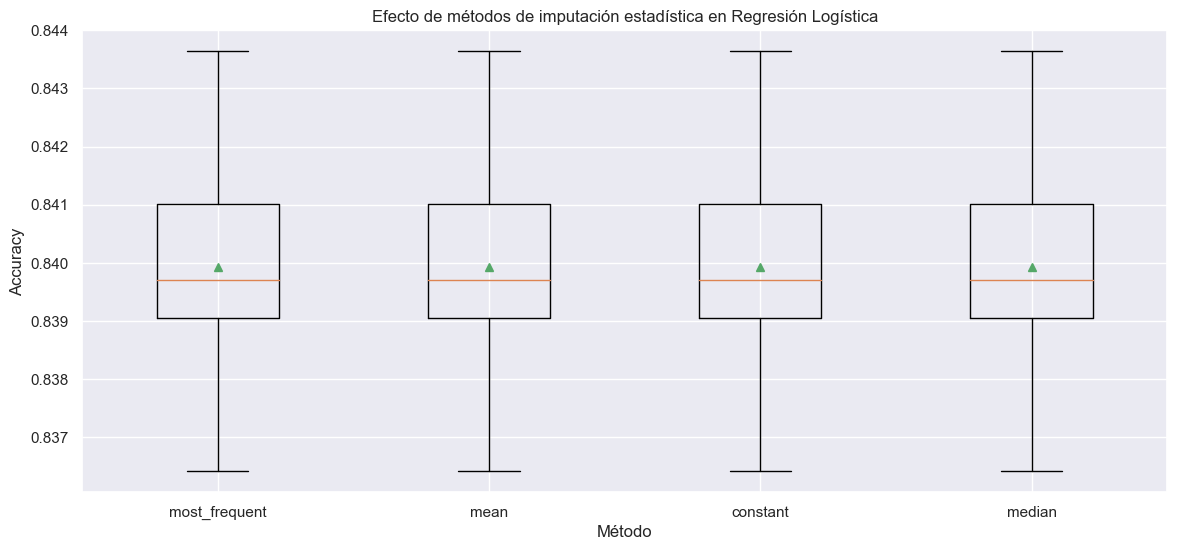

In [47]:
fig,axes = plt.subplots(1,figsize=(14,6))
axes.boxplot(results,labels=param_grid["imputer__strategy"],showmeans=True)
axes.set_xlabel("Método")
axes.set_ylabel("Accuracy")
axes.set_title("Efecto de métodos de imputación estadística en Regresión Logística");
plt.show()

In [48]:
param_idx = np.array([x.mean() for x in results]).argmin()
param_mean_acc = results[param_idx].mean()
print("Mejor accuracy (promedio): ", param_mean_acc)

Mejor accuracy (promedio):  0.8399347337889373


In [49]:
# MICE
results=[]

param_grid = {
    "imputer__n_nearest_features": [None,1,2,3]
}

for param in param_grid["imputer__n_nearest_features"]:
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ( 'imputer' ,IterativeImputer(n_nearest_features=param)), 
                      ('scaler', StandardScaler()),
                      ('logistic', LogisticRegression(max_iter=10000, tol=0.01,class_weight=True))])
    
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)
    scores = cross_val_score(clf, X_train, y_train, scoring= 'accuracy' , cv=cv, n_jobs=-1)    
    results.append(scores)

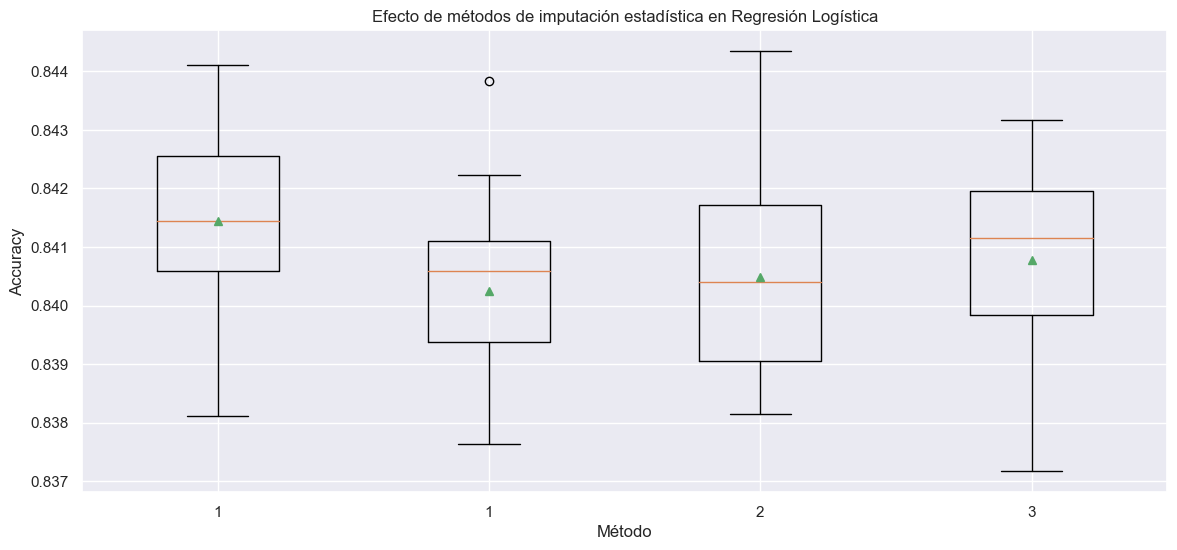

In [50]:
fig,axes = plt.subplots(1,figsize=(14,6))
axes.boxplot(results,labels=param_grid["imputer__n_nearest_features"],showmeans=True)
axes.set_xlabel("Método")
axes.set_ylabel("Accuracy")
axes.set_title("Efecto de métodos de imputación estadística en Regresión Logística");
plt.show()

In [51]:
param_idx = np.array([x.mean() for x in results]).argmin()
param_mean_acc = results[param_idx].mean()
print("Mejor accuracy (promedio): ", param_mean_acc)

Mejor accuracy (promedio):  0.8402535549671093


In [12]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [52]:
categorical_features = ["Location"]
numeric_features = ['MaxTemp', 'Pressure3pm', 'WindGustSpeed', 'Humidity9am','Humidity3pm', 'Month']
no_encoding = ['Cloud3pm','RainToday']
ciclical_features_12 = ['Month']
ciclical_features_18 = ['WindGustDir']


only_imputation_transformer = IterativeImputer(n_nearest_features=2, max_iter=1000)

numeric_transformer = Pipeline(steps=[
    ('Q_transformer', QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=1)),
    ])

categorical_transformer = Pipeline(steps=[
    ('encoder', CountFrequencyEncoder(encoding_method='frequency')),
    ])  



preprocessor = ColumnTransformer(
    transformers=[
        ('only_imputation', only_imputation_transformer, no_encoding),
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ("month_sin", sin_transformer(12), ciclical_features_12),
        ("month_cos", cos_transformer(12), ciclical_features_12),
        ("dir_sin", sin_transformer(18), ciclical_features_18),
        ("dir_cos", cos_transformer(18), ciclical_features_18),
    ])

param_grid = {'logistic__C': np.logspace(-4, 4, 4),'pca__n_components': [1, 3, 5, 7, 11,13], 
             }

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ( 'imputer' ,SimpleImputer()), 
                      ('scaler', StandardScaler()),
                      ('pca', pca),
                      ('logistic', LogisticRegression(max_iter=1000, tol=0.01, class_weight=True))])


cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
search = GridSearchCV(estimator=clf,param_grid=param_grid,cv=cv)
results =search.fit(X_train,y_train)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)


Best parameter (CV score=0.840):
{'logistic__C': 0.046415888336127774, 'pca__n_components': 13}


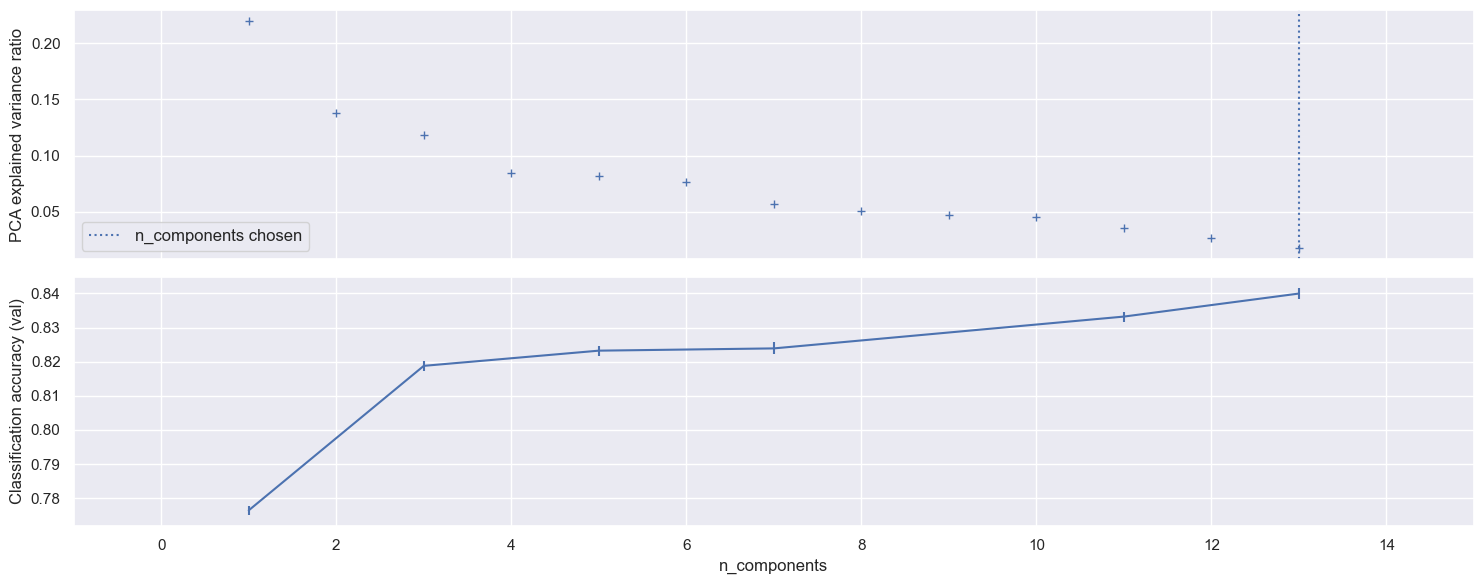

In [54]:
only_imputation_transformer = IterativeImputer(n_nearest_features=None, max_iter=1000)

numeric_transformer = Pipeline(steps=[
    ('Q_transformer', QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=1)),
    ])

categorical_transformer = Pipeline(steps=[
    ('encoder', CountFrequencyEncoder(encoding_method='frequency')),
    ])  



preprocessor = ColumnTransformer(
    transformers=[
        ('only_imputation', only_imputation_transformer, no_encoding),
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ("month_sin", sin_transformer(12), ciclical_features_12),
        ("month_cos", cos_transformer(12), ciclical_features_12),
        ("dir_sin", sin_transformer(18), ciclical_features_18),
        ("dir_cos", cos_transformer(18), ciclical_features_18),
    ])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ( 'imputer' ,SimpleImputer()), 
                      ('scaler', StandardScaler()),
                      ])

results = clf.fit_transform(X_train,y_train)
pca = PCA(n_components=13).fit(results)


fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(15, 6))
ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel('PCA explained variance ratio')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.xlim(-1, 15)

plt.tight_layout()

plt.show()

In [56]:
results = clf.fit_transform(X_train,y_train)
pca = PCA(n_components=2).fit(results).transform(results)


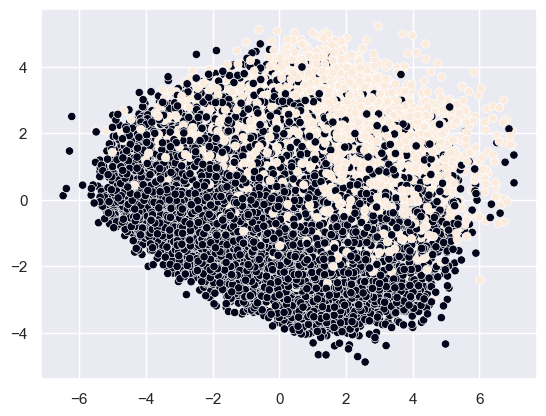

In [57]:
sns.scatterplot(x=pca[:, 0], y=pca[:, 1], c=y_train)
plt.show()

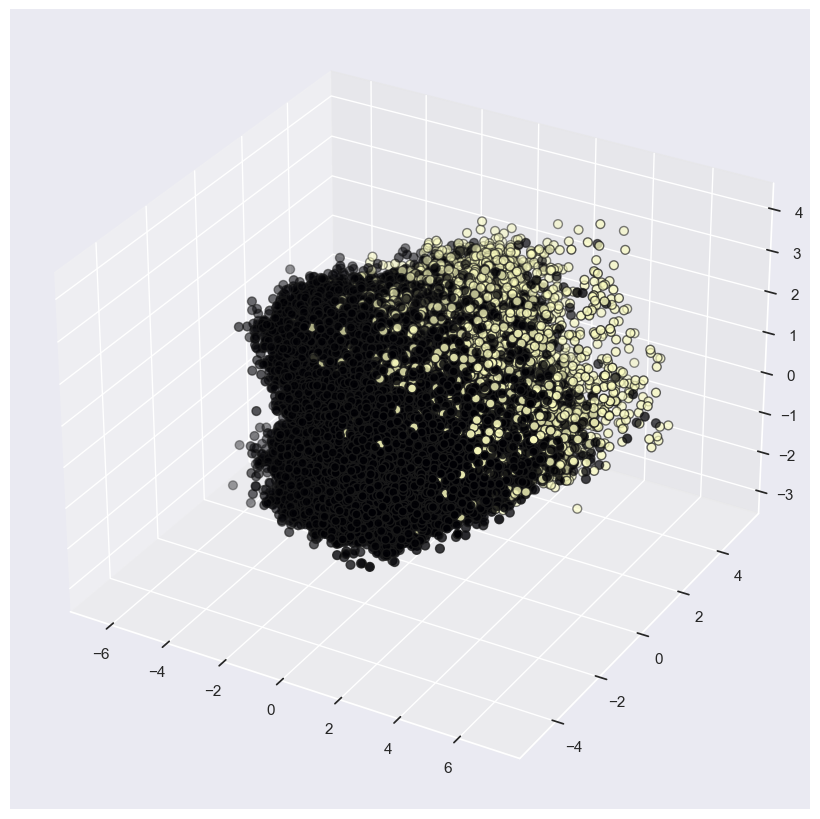

In [61]:
results = clf.fit_transform(X_train,y_train)
pca = PCA(n_components=3).fit(results).transform(results)
fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
p = ax.scatter(pca[:, 0], pca[:, 1], pca[:, 2], c=y_train,
           cmap=plt.cm.magma, edgecolor='k', s=40)
plt.show()

In [85]:
def print_roc(X_test, y_test, model):
    probs = model.predict_proba(X_test)  
    probs = probs[:, 1]  
    fper, tper, thresholds = roc_curve(y_test, probs) 
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [105]:
def proceso_model(modelo, print_roc):
    categorical_features = ["Location"]
    numeric_features = ['MaxTemp', 'Pressure3pm', 'WindGustSpeed', 'Humidity9am','Humidity3pm', 'Month']
    no_encoding = ['Cloud3pm','RainToday']
    ciclical_features_12 = ['Month']
    ciclical_features_18 = ['WindGustDir']
    
    only_imputation_transformer = IterativeImputer(n_nearest_features=2, max_iter=1000)
    numeric_transformer = Pipeline(steps=[('Q_transformer', QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=1)),])
    categorical_transformer = Pipeline(steps=[('encoder', CountFrequencyEncoder(encoding_method='frequency')),])  


    preprocessor = ColumnTransformer(
    transformers=[
        ('only_imputation', only_imputation_transformer, no_encoding),
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ("month_sin", sin_transformer(12), ciclical_features_12),
        ("month_cos", cos_transformer(12), ciclical_features_12),
        ("dir_sin", sin_transformer(18), ciclical_features_18),
        ("dir_cos", cos_transformer(18), ciclical_features_18),
    ])
    pca = PCA(n_components=13)

    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ( 'imputer' ,SimpleImputer()), 
                          ('scaler', StandardScaler()),
                          ('pca', pca),
                          ('model_' , modelo)])



    model = clf.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred) 
    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    print(classification_report(y_test,y_pred,digits=5))
    if print_roc:
        print_roc(X_test, y_test, model)

Accuracy = 0.8415145292413289
ROC Area under Curve = 0.7126272653520299
Cohen's Kappa = 0.48228751981303
              precision    recall  f1-score   support

           0    0.86320   0.94576   0.90260     27601
           1    0.71797   0.47949   0.57498      7948

    accuracy                        0.84151     35549
   macro avg    0.79059   0.71263   0.73879     35549
weighted avg    0.83073   0.84151   0.82935     35549



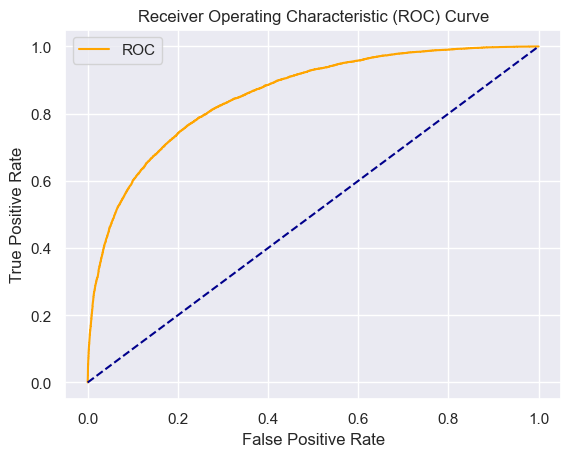

In [100]:
modelo = LogisticRegression(max_iter=1000, tol=0.01, class_weight=True, C=0.0464)
proceso_model(modelo)

Accuracy = 0.848125123069566
ROC Area under Curve = 0.7169291511085961
Cohen's Kappa = 0.4979391218524414
              precision    recall  f1-score   support

           0    0.86428   0.95424   0.90703     27601
           1    0.75113   0.47962   0.58543      7948

    accuracy                        0.84813     35549
   macro avg    0.80771   0.71693   0.74623     35549
weighted avg    0.83898   0.84813   0.83513     35549



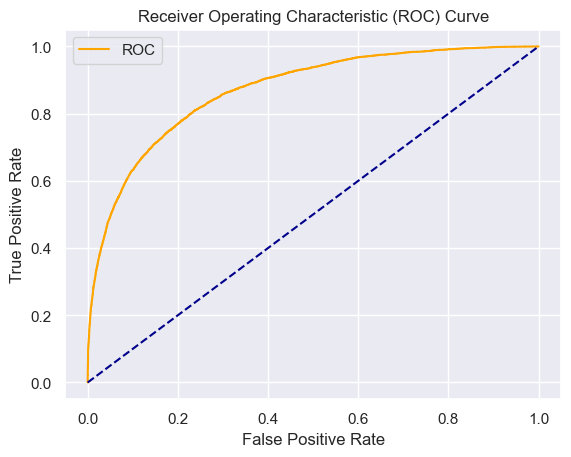

In [99]:
modelo = RandomForestClassifier(max_depth= 16,min_samples_leaf=1,min_samples_split=2,n_estimators=100)
proceso_model(modelo)

Accuracy = 0.8050296773467608
ROC Area under Curve = 0.6856378372941747
Cohen's Kappa = 0.39799961322367294
              precision    recall  f1-score   support

           0    0.85515   0.90160   0.87776     27601
           1    0.57885   0.46968   0.51858      7948

    accuracy                        0.80503     35549
   macro avg    0.71700   0.68564   0.69817     35549
weighted avg    0.79338   0.80503   0.79746     35549



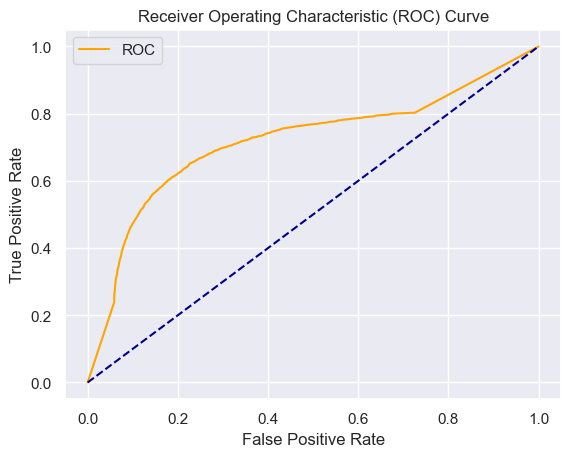

In [97]:
modelo = DecisionTreeClassifier(max_depth=16, max_features='auto')
proceso_model(modelo)

In [114]:
modelo = SGDClassifier(alpha=0.01, max_iter=1000, verbose=0)
proceso_model(modelo, print_roc=False)

Accuracy = 0.8407550142057442
ROC Area under Curve = 0.6971322891939157
              precision    recall  f1-score   support

           0    0.85520   0.95692   0.90321     27601
           1    0.74512   0.43734   0.55118      7948

    accuracy                        0.84076     35549
   macro avg    0.80016   0.69713   0.72719     35549
weighted avg    0.83059   0.84076   0.82450     35549

